## Problem Statement:
Create a LangGraph agent that classifies the sentiment of a user’s message into one of:


*   Positive
*   Negative
*   Neutral



# Agent Structure:

**Nodes**: classify_sentiment_node:

Uses ChatOpenAI to classify the sentiment

Returns one of "positive", "negative", "neutral" based on the response

**respond_positive_node**: Says something encouraging like “Glad to hear that!”

**respond_negative_node:** Apologizes or offers support

**respond_neutral_node:** Gives a neutral acknowledgment

**fallback_node:** Handles unclear output

In [ ]:
!pip install langchain
!pip install openai
!pip install langchain-community langchain
!pip install langgraph
!pip install -U langchain langchain-openai

In [3]:
import os

os.environ["OPENAI_API_KEY"] = 'OPENAI_API_KEY'
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = 'LANGCHAIN_API_KEY'
os.environ["LANGCHAIN_PROJECT"] = "Langgraph Agents"
os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com"

In [4]:
from langchain.chat_models import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, List
from langchain_core.messages import HumanMessage

In [8]:
from langchain_core.output_parsers import StrOutputParser

In [43]:
class SentimentAnalysis(TypedDict):
  messages:List[HumanMessage]
  sentiment: str
  response: str

In [32]:
llm = ChatOpenAI()
parser = StrOutputParser()

In [55]:
#This node classifies the response
def classification_node(state: SentimentAnalysis) -> SentimentAnalysis:
  response = state['messages']
  prompt = f"What is the sentiment of this sentence? Respond with only one word: Positive, Negative, or Neutral.\nSentence: '{response}'"
  result = llm.invoke(prompt)
  sentiment = parser.invoke(result)
  if sentiment.strip().lower() == "positive":
    state["sentiment"] = "positive"
    return state
  elif sentiment.strip().lower() == "negative":
    state["sentiment"] = "negative"
    return state
  elif sentiment.strip().lower() == "neutral":
    state["sentiment"] = "neutral"
    return state
  else:
    state["sentiment"] = "unclear"
    return state

def positive_node(state: SentimentAnalysis)-> SentimentAnalysis:
  state["response"] = "Glad to hear this"
  return state

def negative_node(state: SentimentAnalysis)-> SentimentAnalysis:
  state["response"] = "Thanks for the feedback. We will work on this"
  return state

def neutral_node(state: SentimentAnalysis)-> SentimentAnalysis:
  state["response"] = "Thank you for your feedback"
  return state

def unclear_node(state: SentimentAnalysis)-> SentimentAnalysis:
  state["sentiment"] = "Sorry, I couldn't understand the sentimentt"
  return state

In [56]:
graph = StateGraph(SentimentAnalysis)

graph.add_node("classification", classification_node)
graph.add_node("positive", positive_node)
graph.add_node("negative", negative_node)
graph.add_node("neutral", neutral_node)
graph.add_node("unclear", unclear_node)

graph.add_edge(START,"classification")

#Since this is a graph node and it returns state, so we have to return state["sentiment"] instead of a string
graph.add_conditional_edges(
    "classification",
    lambda state: state["sentiment"],
    {
        "positive": "positive",
        "negative": "negative",
        "neutral": "neutral",
        "unclear": "unclear"
    }
)
graph.add_edge("positive", END)
graph.add_edge("negative", END)
graph.add_edge("neutral", END)
graph.add_edge("unclear", END)

app = graph.compile()

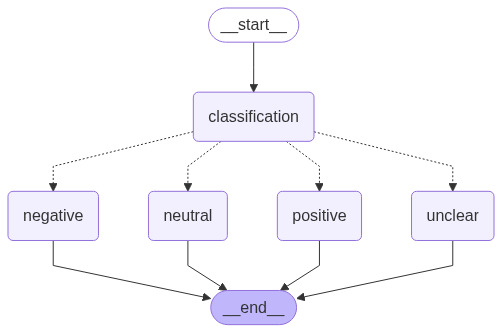

In [57]:
app

In [58]:
result = app.invoke({"messages":[HumanMessage(content="Hi, this restaurent servers awesome food?")]})

In [59]:
result

{'messages': [HumanMessage(content='Hi, this restaurent servers awesome food?', additional_kwargs={}, response_metadata={})],
 'sentiment': 'positive',
 'response': 'Glad to hear this'}

Langsmith tracebility: https://smith.langchain.com/public/c79f736f-79e9-44da-8dfe-89d06e0bde9e/r